In [2]:
import sys
sys.path.append('/Users/dzhansavarmail.ru/Desktop/artifact/ct_simulation-main/src/CT_simulation')
import gen_and_deg
from gen_and_deg import *
import torch
import torch.nn as nn

In [3]:
from torch.nn.functional import l1_loss
from pytorch_msssim import SSIM

In [4]:
device = 'cpu'

In [10]:
def generate_batch(batch_size, device='cpu'):
    """
    Генерирует батч матриц truth размером [batch_size, 1, 512, 512].
    
    Аргументы:
        batch_size (int): Количество матриц в батче.
        device (str): Устройство для вычислений ('cpu' или 'cuda').
    
    Возвращает:
        torch.Tensor: Тензор размером [batch_size, 1, 512, 512] с значениями в [0, 1].
    """
    # Инициализация пустого тензора для батча
    batch = torch.zeros(batch_size, 1, 512, 512, dtype=torch.float32, device=device)
    
    # Генерация матриц по одной и добавление в батч
    for b in range(batch_size):
        truth = generate2_v2()  # Вызов вашей функции
        # Если generate2 возвращает [512, 512], добавляем канал
        if truth.dim() == 2:
            truth = truth.unsqueeze(0)  # Преобразование в [1, 512, 512]
        batch[b] = truth.to(device)
    
    return batch

In [ ]:
ssim_module = SSIM(data_range=4000.0, size_average=True, channel=1)

def combined_loss(output, target):
    l1 = l1_loss(output, target)  # L1 Loss
    ssim = 1 - ssim_module(output, target)  # 1 - SSIM, чтобы минимизировать
    return 0.5 * l1 + 0.5 * ssim  # Комбинация с равными весами

### Временные меры

In [5]:
def generate_v2(image_size=(512, 512), radius=(50, 90), num_vertices=8, mu=4000):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    image_array = torch.zeros(image_size, dtype=torch.float32, device=device)
    
    angles = torch.linspace(0, 2 * torch.pi, num_vertices, device=device)
    radii = torch.randint(radius[0], radius[1], (num_vertices,), device=device)
    x_center = torch.randint(max(radii), image_size[0] - max(radii), (1,), device=device)
    y_center = torch.randint(max(radii), image_size[1] - max(radii), (1,), device=device)
    x_vertices = radii * torch.cos(angles) + x_center
    y_vertices = radii * torch.sin(angles) + y_center
    
    y, x = torch.meshgrid(torch.arange(image_size[0], device=device),
                         torch.arange(image_size[1], device=device),
                         indexing='ij')
    px = x.reshape(-1)
    py = y.reshape(-1)
    
    cross_products = []
    for i in range(num_vertices):
        a_x = x_vertices[i]
        a_y = y_vertices[i]
        b_x = x_vertices[(i+1) % num_vertices]
        b_y = y_vertices[(i+1) % num_vertices]
        cp = (b_x - a_x) * (py - a_y) - (b_y - a_y) * (px - a_x)
        cross_products.append(cp)
    cross_products = torch.stack(cross_products, dim=0)
    min_cp = cross_products.min(dim=0).values
    mask_flat = min_cp >= 0
    mask = mask_flat.view(image_size[0], image_size[1])
    
    image_array[mask] = mu
    return image_array

In [6]:
def generate2_v2(image_size=(512, 512), radius=(50, 90), num_vertices=8, mu=4000):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    num_arrays = torch.randint(1, 4, (1,), device=device).item()
    final_array = torch.zeros(image_size, dtype=torch.float32, device=device)
    used_pixels = torch.zeros(image_size, dtype=torch.bool, device=device)

    for _ in range(num_arrays):
        while True:
            vertices = torch.randint(5, num_vertices+1, (1,), device=device).item()
            shift = torch.randint(0, (radius[1] - radius[0]) // 3, (1,), device=device).item()
            rad = (radius[0] + shift, radius[1] - shift)
            new_array = generate_v2(image_size=image_size, radius=rad, num_vertices=vertices, mu=mu)
            overlap = torch.logical_and(new_array > 0, used_pixels)
            if not torch.any(overlap):
                break
        used_pixels = torch.logical_or(used_pixels, new_array > 0)
        final_array += new_array

    return final_array

In [7]:
def degradation_v2(tensor, theta=np.linspace(0., 180., 128, endpoint=False), max_p=1e5, sigma=1e-1):
    """
    Применяет процесс деградации к батчу изображений, представленных тензором PyTorch.
    
    Аргументы:
        tensor (torch.Tensor): Входной тензор размером [batch_size, 1, H, W].
        theta (np.ndarray): Углы для преобразования Радона.
        max_p (float): Максимальное значение для обрезки.
        sigma (float): Дисперсия гауссовского шума.
    
    Возвращает:
        torch.Tensor: Тензор с артефактами размером [batch_size, 1, H, W].
    """
    # Получаем размеры батча
    batch_size, _, height, width = tensor.shape
    device = tensor.device  # Сохраняем устройство (CPU или GPU) для возврата результата
    
    # Преобразуем тензор в NumPy массив [batch_size, H, W], убирая канал
    tensor_np = tensor.cpu().numpy()[:, 0, :, :]
    
    # Список для хранения обработанных изображений
    degraded_images = []
    
    # Обрабатываем каждое изображение в батче
    for i in range(batch_size):
        image = tensor_np[i]
        
        # Шаг 1: Применяем преобразование Радона
        sinogram = radon(image, theta=theta, circle=False)
        
        # Шаг 2: Добавляем гауссовский шум
        sinogram_noisy = random_noise(sinogram, mode='gaussian', var=sigma, clip=False)
        
        # Шаг 3: Обрезаем значения
        sinogram_clipped = np.clip(sinogram_noisy, None, max_p)
        
        # Шаг 4: Применяем обратное преобразование Радона
        image_real = iradon(sinogram_clipped, theta=theta, circle=False)
        
        # Добавляем обработанное изображение в список
        degraded_images.append(image_real)
    
    # Преобразуем список в NumPy массив [batch_size, H, W]
    degraded_np = np.stack(degraded_images, axis=0)
    
    # Преобразуем NumPy массив обратно в тензор [batch_size, 1, H, W]
    degraded_tensor = torch.from_numpy(degraded_np).unsqueeze(1).float().to(device)
    
    return degraded_tensor

### Autoencoder_v1
- features: матрица HU (с артефактами)
- target: матрица HU (без артефактов)
- encoder: 512x512 conv-> 256x256 BN, ReLU, conv-> 128x128 BN, ReLU, conv-> 64x64 BN, ReLU
- decoder: 64x64 conv-> 128x128 BN, ReLU, conv-> 256x256 BN, ReLU, conv-> 512x512
- loss = 0.5 MAE + 0.5 SSIM

In [28]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        
        # Кодировщик (Encoder): 512 -> 256 -> 128 -> 64 -> 32
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=2, padding=1),    # 512x512 -> 256x256
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),   # 256x256 -> 128x128
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),  # 128x128 -> 64x64
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1), # 64x64 -> 32x32
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1), # 32x32 -> 32x32 (сужение каналов)
            nn.BatchNorm2d(512),
            nn.ReLU()
        )
        
        # Декодировщик (Decoder): 32 -> 64 -> 128 -> 256 -> 512
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(512, 256, kernel_size=3, stride=1, padding=1),  # 32x32 -> 32x32
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.ConvTranspose2d(256, 128, kernel_size=3, stride=2, padding=1, output_padding=1), # 32x32 -> 64x64
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1),  # 64x64 -> 128x128
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),   # 128x128 -> 256x256
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 1, kernel_size=3, stride=2, padding=1, output_padding=1)     # 256x256 -> 512x512
        )
    
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x


In [18]:
model = Autoencoder()

In [ ]:
# Предполагаем, что truth — это тензор размером [batch_size, 1, 512, 512]
batch_size = 4
truth = generate_batch(batch_size, device='cpu')
model = Autoencoder()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
num_epochs = 100  # Для примера

for epoch in range(num_epochs):
    artifact = degradation_v2(truth)
    output = model(artifact)
    loss = combined_loss(output, truth)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if (epoch + 1) % 10 == 0:  # Печать каждые 10 эпох
            print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}")

### Результаты после 260 эпох (batch_size = 10)

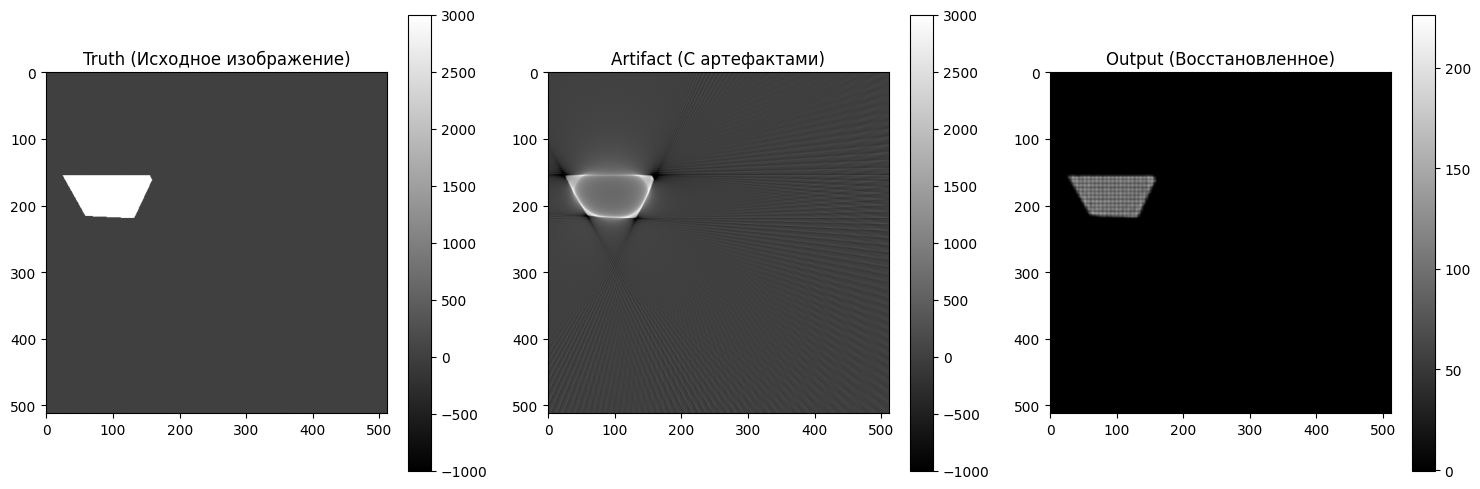

In [34]:
model.eval()
with torch.no_grad():
    # Берем первый пример из батча
    truth_example = truth[1:2]  # [1, 1, 512, 512]
    artifact_example = degradation_v2(truth_example)
    output_example = model(artifact_example)

truth_np = truth_example.squeeze().cpu().numpy()
artifact_np = artifact_example.squeeze().cpu().numpy()
output_np = output_example.squeeze().cpu().numpy()

# Визуализация
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.imshow(truth_np, cmap='gray', vmin=-1000, vmax=3000)
plt.title("Truth (Исходное изображение)")
plt.colorbar()

plt.subplot(1, 3, 2)
plt.imshow(artifact_np, cmap='gray', vmin=-1000, vmax=3000)
plt.title("Artifact (С артефактами)")
plt.colorbar()

plt.subplot(1, 3, 3)
plt.imshow(output_np, cmap='gray')
plt.title("Output (Восстановленное)")
plt.colorbar()

plt.tight_layout()
plt.show()

### U-Net

In [8]:
class Mish(nn.Module):
    def forward(self, x):
        return x * torch.tanh(torch.nn.functional.softplus(x))

In [9]:
class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()

        # Кодировщик
        self.enc1 = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            Mish(),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            Mish()
        )  # 512x512
        self.pool1 = nn.MaxPool2d(2, 2)  # 256x256

        self.enc2 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            Mish(),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            Mish()
        )  # 256x256
        self.pool2 = nn.MaxPool2d(2, 2)  # 128x128

        self.enc3 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            Mish(),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            Mish()
        )  # 128x128
        self.pool3 = nn.MaxPool2d(2, 2)  # 64x64

        self.enc4 = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            Mish(),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            Mish()
        )  # 64x64
        self.pool4 = nn.MaxPool2d(2, 2)  # 32x32

        # Бутылочное горлышко
        self.bottleneck = nn.Sequential(
            nn.Conv2d(512, 1024, kernel_size=3, padding=1),
            nn.BatchNorm2d(1024),
            Mish(),
            nn.Conv2d(1024, 1024, kernel_size=3, padding=1),
            nn.BatchNorm2d(1024),
            Mish()
        )  # 32x32

        # Декодировщик
        self.upconv4 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
        self.dec4 = nn.Sequential(
            nn.Conv2d(1024, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            Mish(),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            Mish()
        )

        self.upconv3 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.dec3 = nn.Sequential(
            nn.Conv2d(512, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            Mish(),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            Mish()
        )

        self.upconv2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.dec2 = nn.Sequential(
            nn.Conv2d(256, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            Mish(),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            Mish()
        )

        self.upconv1 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.dec1 = nn.Sequential(
            nn.Conv2d(128, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            Mish(),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            Mish()
        )

        self.outconv = nn.Conv2d(64, 1, kernel_size=1)

    def forward(self, x):
        e1 = self.enc1(x)
        e2 = self.enc2(self.pool1(e1))
        e3 = self.enc3(self.pool2(e2))
        e4 = self.enc4(self.pool3(e3))
        
        b = self.bottleneck(self.pool4(e4))

        d4 = self.upconv4(b)
        d4 = torch.cat([d4, e4], dim=1)
        d4 = self.dec4(d4)

        d3 = self.upconv3(d4)
        d3 = torch.cat([d3, e3], dim=1)
        d3 = self.dec3(d3)

        d2 = self.upconv2(d3)
        d2 = torch.cat([d2, e2], dim=1)
        d2 = self.dec2(d2)

        d1 = self.upconv1(d2)
        d1 = torch.cat([d1, e1], dim=1)
        d1 = self.dec1(d1)

        out = self.outconv(d1)
        return out

In [19]:
def train(model, truth, loss, num_epochs=50, device='cpu'):
    optimizer = torch.optim.RAdam(model.parameters(), lr=0.001)

    # Обучение
    model.train()
    for epoch in range(num_epochs):
        print('Epoch ' + str(epoch+1))
        artifact = degradation_v2(truth)
        output = model(artifact)
        loss = combined_loss(output, truth)
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}")

    return model

In [ ]:
batch_size = 4
num_epochs = 10

truth = generate_batch(batch_size, device=device)
model = UNet().to(device)
model = train(model, truth, combined_loss, num_epochs=num_epochs, device=device)

### Результаты после ? эпох (batch_size = 4)

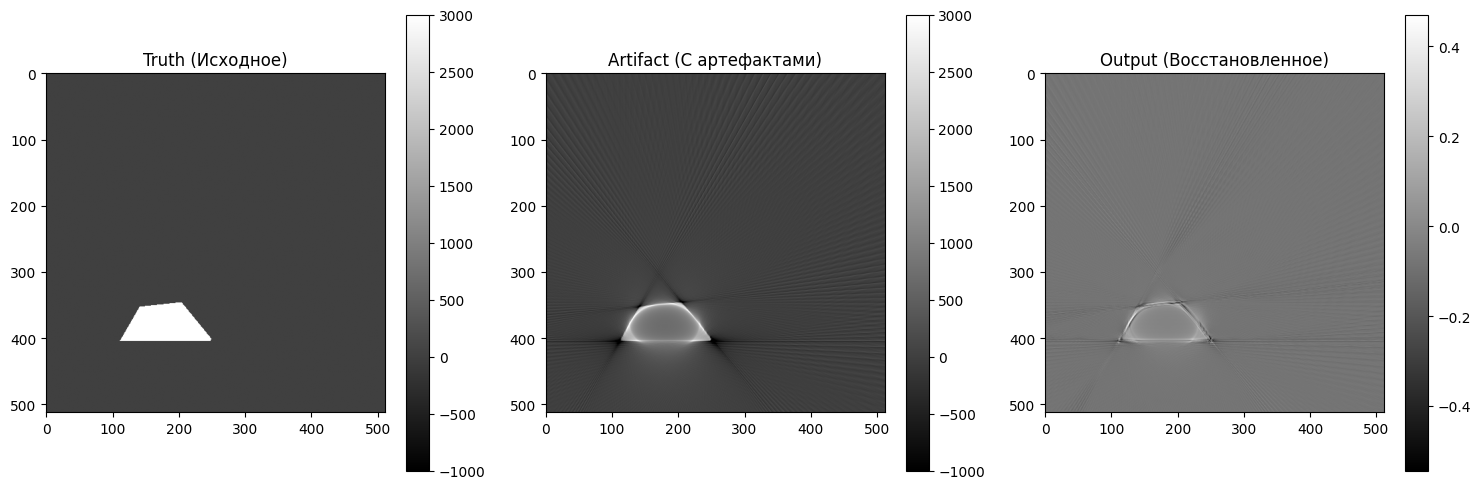

In [23]:
def visualize(model, truth, device='cpu'):
    model.eval()
    with torch.no_grad():
        truth_example = truth[0:1]  # Берем первый пример из батча
        artifact_example = degradation_v2(truth_example)
        output_example = model(artifact_example)

    truth_np = truth_example.squeeze().cpu().numpy()
    artifact_np = artifact_example.squeeze().cpu().numpy()
    output_np = output_example.squeeze().cpu().numpy()

    plt.figure(figsize=(15, 5))
    
    plt.subplot(1, 3, 1)
    plt.imshow(truth_np, cmap='gray', vmin=-1000, vmax=3000)
    plt.title("Truth (Исходное)")
    plt.colorbar()
    
    plt.subplot(1, 3, 2)
    plt.imshow(artifact_np, cmap='gray', vmin=-1000, vmax=3000)
    plt.title("Artifact (С артефактами)")
    plt.colorbar()
    
    plt.subplot(1, 3, 3)
    plt.imshow(output_np, cmap='gray')
    plt.title("Output (Восстановленное)")
    plt.colorbar()
    
    plt.tight_layout()
    plt.show()

visualize(model, truth)